In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import plotly.io as pio
from plotly import *
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go  
import pandas as pd
from IPython.display import Image
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler, normalize
import kaleido
from dotenv import load_dotenv

load_dotenv()

import os,sys
sys.path.append(os.path.abspath(os.path.join('..')))

from scripts.utils import *
from DB_Connection.connection import ConnectionToPostgres

username = os.getenv('DB_USERNAME')
password = os.getenv('DB_PASSWORD')
name = os.getenv('DB_NAME')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')

In [2]:
db = ConnectionToPostgres(dbname=name, user=username, password=password, host=host, port=port)
db.connect()

query = 'select * from xdr_data'
result = db.execute(query)

df = pd.DataFrame(result, columns=[desc[0] for desc in db.cursor.description])#-
# df.head()

db.close_connection()

Connected to the PostgreSQL database
PostgreSQL connection is closed


In [3]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [5]:
df = df[['MSISDN/Number','Handset Type','Avg RTT DL (ms)','Avg RTT UL (ms)',
                 'TCP DL Retrans. Vol (Bytes)','TCP UL Retrans. Vol (Bytes)',
                 'Avg Bearer TP DL (kbps)','Avg Bearer TP UL (kbps)']]

In [6]:
df['MSISDN/Number'].fillna(value=df['MSISDN/Number'].mean(), inplace=True)

C:\Users\Leul\AppData\Local\Temp\ipykernel_13576\278324772.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [7]:
df.head(10)

,MSISDN/Number,Handset Type,Avg RTT DL (ms),Avg RTT UL (ms),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
0,3.366496e+10,Samsung Galaxy A5 Sm-A520F,42.0,5.0,NaN,NaN,23.0,44.0
1,3.368185e+10,Samsung Galaxy J5 (Sm-J530),65.0,5.0,NaN,NaN,16.0,26.0
2,3.376063e+10,Samsung Galaxy A8 (2018),NaN,NaN,NaN,NaN,6.0,9.0
3,3.375034e+10,undefined,NaN,NaN,NaN,NaN,44.0,44.0
4,3.369980e+10,Samsung Sm-G390F,NaN,NaN,NaN,NaN,6.0,9.0
5,3.366819e+10,undefined,NaN,NaN,NaN,NaN,70.0,54.0
6,3.366537e+10,Huawei Mate 20 Lite,102.0,5.0,NaN,NaN,22.0,38.0
7,3.376349e+10,undefined,39.0,18.0,19520.0,NaN,3698.0,416.0
8,3.369874e+10,Samsung Galaxy A8 (2018),NaN,NaN,NaN,NaN,46.0,49.0
9,3.365922e+10,Samsung Galaxy Note 8 (Sm-N950F Ds),97.0,7.0,3231397.0,7230.0,3845.0,2535.0


Filling missing value with mean

In [11]:
df['Avg RTT DL (ms)'].fillna(value=df['Avg RTT DL (ms)'].mean(), inplace=True)
df['Avg Bearer TP DL (kbps)'].fillna(value=df['Avg Bearer TP DL (kbps)'].mean(), inplace=True)
df['Avg Bearer TP UL (kbps)'].fillna(value=df['Avg Bearer TP UL (kbps)'].mean(), inplace=True)
df['TCP DL Retrans. Vol (Bytes)'].fillna(value=df['TCP DL Retrans. Vol (Bytes)'].mean(), inplace=True)
df['TCP UL Retrans. Vol (Bytes)'].fillna(value=df['TCP UL Retrans. Vol (Bytes)'].mean(), inplace=True)
df['Avg Bearer TP DL (kbps)'].fillna(value=df['Avg Bearer TP DL (kbps)'].mean(), inplace=True)
df['Avg Bearer TP UL (kbps)'].fillna(value=df['Avg Bearer TP UL (kbps)'].mean(), inplace=True)
# df['Total_Avg_RTT'].fillna(value=df['Total_Avg_RTT'].mean(),inplace=True)

C:\Users\Leul\AppData\Local\Temp\ipykernel_13576\4255287195.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Leul\AppData\Local\Temp\ipykernel_13576\4255287195.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

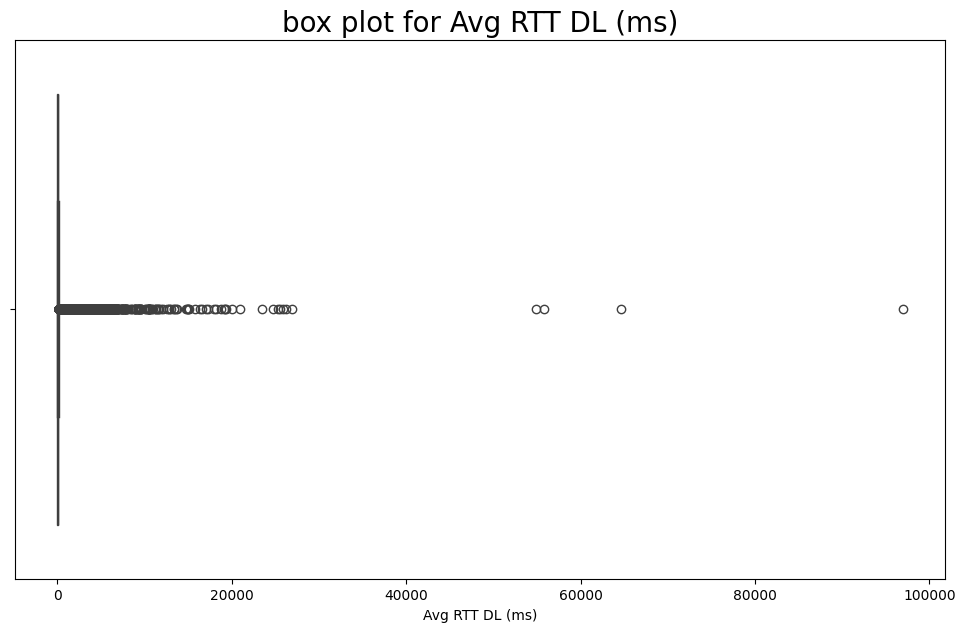

In [12]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='Avg RTT DL (ms)')
plt.title("box plot for Avg RTT DL (ms)", size=20)
plt.show()

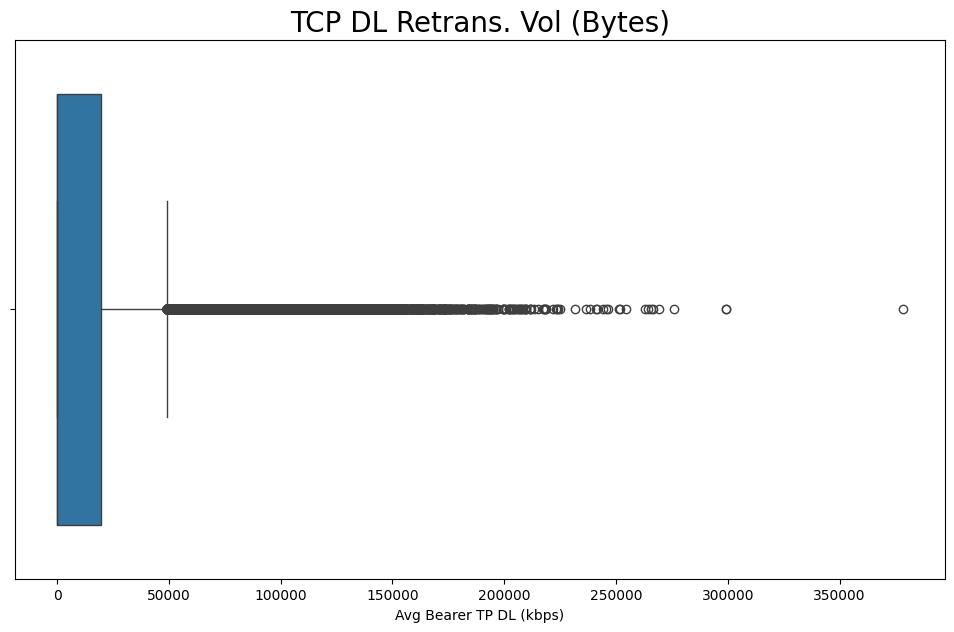

In [13]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='Avg Bearer TP DL (kbps)')
plt.title("TCP DL Retrans. Vol (Bytes)", size=20)
plt.show()

In [14]:
df['Avg RTT DL (ms)'] = np.where(df['Avg RTT DL (ms)'] > 220, 54, df['Avg RTT DL (ms)'])

In [15]:
#Printing the median and percentile of Avg RTT UL (ms)
df['Avg RTT UL (ms)'].describe()

count    122189.000000
mean         17.662883
std          84.793524
min           0.000000
25%           2.000000
50%           5.000000
75%          15.000000
max        7120.000000
Name: Avg RTT UL (ms), dtype: float64

In [16]:
df['Avg RTT DL (ms)'].describe()

count    150001.000000
mean         64.169484
std          37.817597
min           0.000000
25%          35.000000
50%          54.000000
75%         104.000000
max         220.000000
Name: Avg RTT DL (ms), dtype: float64

In [17]:
avg_tp_uldl_columns = [
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)'
]
avg_tp_uldl = df[avg_tp_uldl_columns].sum()

<Axes: xlabel='Handset Type'>

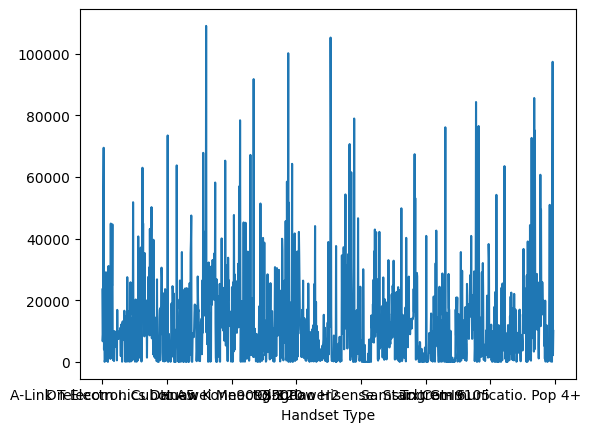

In [18]:
handsets_data = df.groupby('Handset Type')


handsets_tp = handsets_data[avg_tp_uldl_columns].mean().sum(axis=1)
handsets_tp.plot()

In [19]:
df['Total_Avg_RTT'] = df['Avg RTT DL (ms)'] + \
                                      df['Avg RTT UL (ms)']

df['Total_Avg_Bearer_TP'] = df['Avg Bearer TP DL (kbps)'] + \
                                      df['Avg Bearer TP DL (kbps)']

df['Total_Avg_TCP'] = df['TCP DL Retrans. Vol (Bytes)'] + \
                                      df['TCP UL Retrans. Vol (Bytes)']

df['Total_Avg_RTT'].fillna(value=df['Total_Avg_RTT'].mean(),inplace=True)

C:\Users\Leul\AppData\Local\Temp\ipykernel_13576\2212561478.py:10: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [20]:
sorted_by_tcp = df.sort_values(
    'Total_Avg_TCP', ascending=False)
top_10 = sorted_by_tcp.head(10)['Total_Avg_TCP']
last_10 = sorted_by_tcp.tail(10)['Total_Avg_TCP']
most_10 = df['Total_Avg_TCP'].value_counts().head(10)

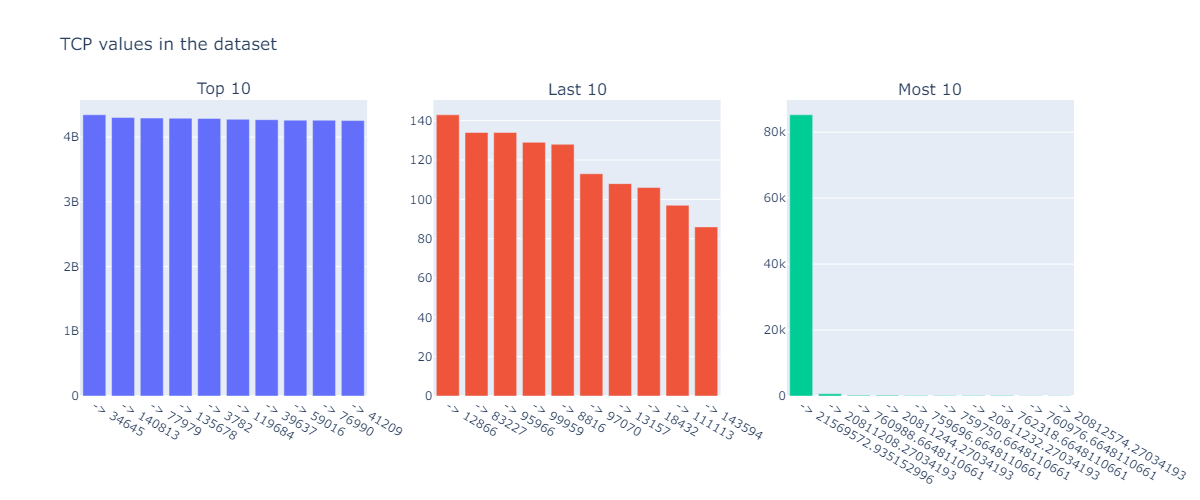

In [21]:
def mult_hist(sr, rows, cols, title_text, subplot_titles, interactive=False):
    figure = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles)
    for i in range(rows):
        for j in range(cols):
            x = ["-> " + str(i) for i in sr[i+j].index]
            figure.add_trace(go.Bar(x=x, y=sr[i+j].values), row=i+1, col=j+1)
    figure.update_layout(showlegend=False, title_text=title_text)
    if(interactive):
        figure.show()
    else:
        return Image(pio.to_image(figure, format='png', width=1200))
mult_hist([top_10, last_10, most_10], 1,
          3, "TCP values in the dataset", ['Top 10', 'Last 10', 'Most 10'])

In [22]:
sorted_by_RTT = df.sort_values(
    'Total_Avg_RTT', ascending=False)
top_10 = sorted_by_RTT.head(10)['Total_Avg_RTT']
last_10 = sorted_by_RTT.tail(10)['Total_Avg_RTT']
most_10 = df['Total_Avg_RTT'].value_counts().head(10)

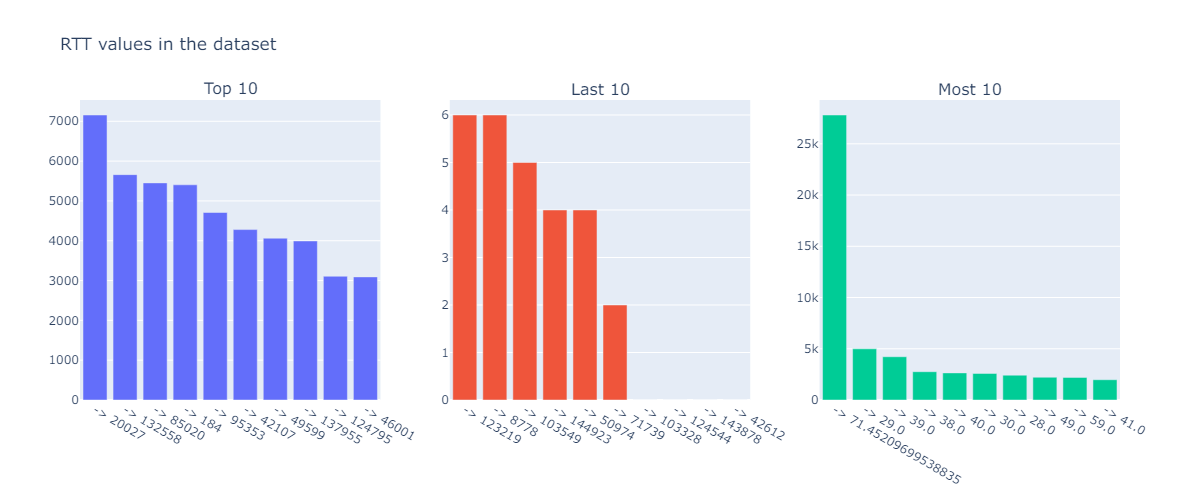

In [23]:
mult_hist([top_10, last_10, most_10], 1,
          3, "RTT values in the dataset", ['Top 10', 'Last 10', 'Most 10'])

In [24]:

sorted_by_Bearer_TP = df.sort_values(
    'Total_Avg_Bearer_TP', ascending=False)
top_10 = sorted_by_Bearer_TP.head(10)['Total_Avg_Bearer_TP']
last_10 = sorted_by_Bearer_TP.tail(10)['Total_Avg_Bearer_TP']
most_10 = df['Total_Avg_Bearer_TP'].value_counts().head(10)

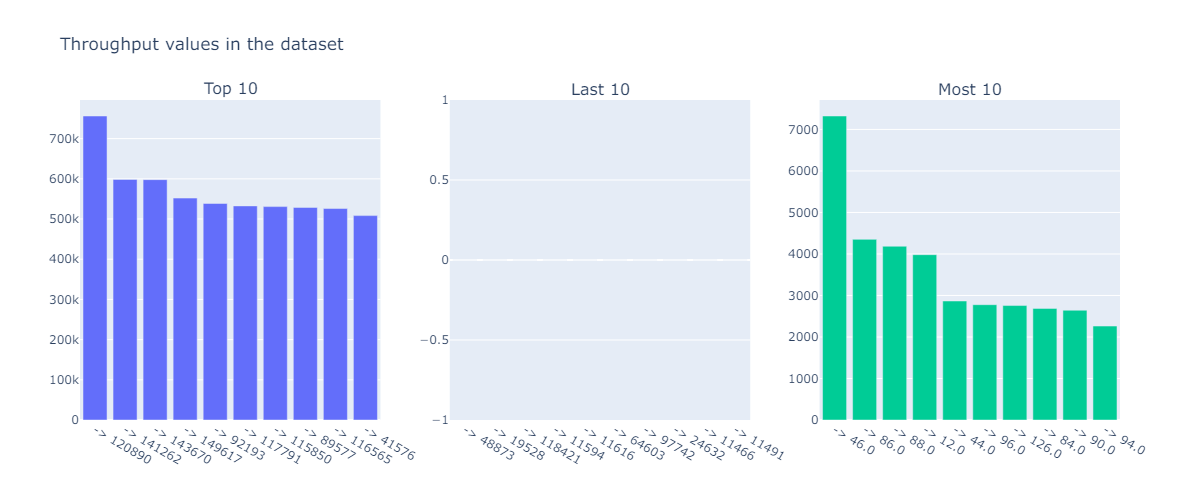

In [25]:
mult_hist([top_10, last_10, most_10, top_10], 1,
          3, "Throughput values in the dataset", ['Top 10', 'Last 10', 'Most 10'])

Compute & report:

The distribution of the average throughput per handset type and provide interpretation for your findings.

In [26]:
handset_type_agg = df.groupby('Handset Type').agg(
    {'Total_Avg_Bearer_TP': 'mean', 'Total_Avg_TCP': 'mean'})
handset_type_agg.head()

,Total_Avg_Bearer_TP,Total_Avg_TCP
Handset Type,,
A-Link Telecom I. Cubot A5,46368.0,2.156957e+07
A-Link Telecom I. Cubot Note Plus,13054.0,6.162130e+05
A-Link Telecom I. Cubot Note S,17030.0,4.141173e+07
A-Link Telecom I. Cubot Nova,111334.0,1.371700e+05
A-Link Telecom I. Cubot Power,138252.0,8.041000e+03


C:\Users\Leul\AppData\Local\Temp\ipykernel_13576\1996917590.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




,Total_Avg_Bearer_TP
count,1396.000000
mean,22653.920712
std,27301.590942
min,0.000000
25%,2096.214286
50%,15448.716867
75%,31590.412162
max,209338.000000


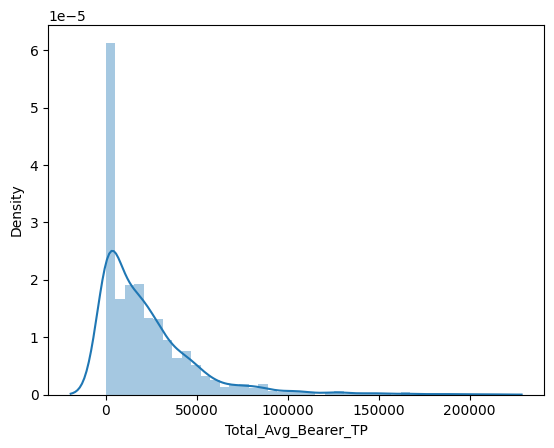

In [27]:
sorted_by_tp = handset_type_agg.sort_values('Total_Avg_Bearer_TP', ascending=False)
top_tp = sorted_by_tp['Total_Avg_Bearer_TP']

sns.distplot(top_tp)
pd.DataFrame(top_tp.describe()) 

perform a k-means clustering (where k = 3)

In [28]:
metrics = df[[
    "Total_Avg_RTT",
    "Total_Avg_Bearer_TP",
    "Total_Avg_TCP"]].copy()
metrics.head()

,Total_Avg_RTT,Total_Avg_Bearer_TP,Total_Avg_TCP
0,47.000000,46.0,2.156957e+07
1,70.000000,32.0,2.156957e+07
2,71.452097,12.0,2.156957e+07
3,71.452097,88.0,2.156957e+07
4,71.452097,12.0,2.156957e+07


In [29]:

scaler = StandardScaler()
scaled_array = scaler.fit_transform(metrics)
pd.DataFrame(scaled_array).head()

,0,1,2
0,-2.910704e-01,-0.553863,3.145329e-17
1,-1.728533e-02,-0.554155,3.145329e-17
2,1.691618e-16,-0.554572,3.145329e-17
3,1.691618e-16,-0.552987,3.145329e-17
4,1.691618e-16,-0.554572,3.145329e-17


In [30]:
data_normalized = normalize(scaled_array)
pd.DataFrame(data_normalized).head(5)

,0,1,2
0,-4.652002e-01,-0.885205,5.026989e-17
1,-3.117707e-02,-0.999514,5.673143e-17
2,3.050311e-16,-1.000000,5.671632e-17
3,3.059056e-16,-1.000000,5.687891e-17
4,3.050311e-16,-1.000000,5.671632e-17


In [31]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_normalized)
kmeans.labels_

array([2, 0, 0, ..., 2, 2, 1], dtype=int32)

In [32]:
df.insert(0, 'Cluster', kmeans.labels_)
df.head(10)

,Cluster,MSISDN/Number,Handset Type,Avg RTT DL (ms),Avg RTT UL (ms),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),Total_Avg_RTT,Total_Avg_Bearer_TP,Total_Avg_TCP
0,2,3.366496e+10,Samsung Galaxy A5 Sm-A520F,42.000000,5.0,2.080991e+07,759658.664811,23.0,44.0,47.000000,46.0,2.156957e+07
1,0,3.368185e+10,Samsung Galaxy J5 (Sm-J530),65.000000,5.0,2.080991e+07,759658.664811,16.0,26.0,70.000000,32.0,2.156957e+07
2,0,3.376063e+10,Samsung Galaxy A8 (2018),109.795706,NaN,2.080991e+07,759658.664811,6.0,9.0,71.452097,12.0,2.156957e+07
3,0,3.375034e+10,undefined,109.795706,NaN,2.080991e+07,759658.664811,44.0,44.0,71.452097,88.0,2.156957e+07
4,0,3.369980e+10,Samsung Sm-G390F,109.795706,NaN,2.080991e+07,759658.664811,6.0,9.0,71.452097,12.0,2.156957e+07
5,0,3.366819e+10,undefined,109.795706,NaN,2.080991e+07,759658.664811,70.0,54.0,71.452097,140.0,2.156957e+07
6,0,3.366537e+10,Huawei Mate 20 Lite,102.000000,5.0,2.080991e+07,759658.664811,22.0,38.0,107.000000,44.0,2.156957e+07
7,2,3.376349e+10,undefined,39.000000,18.0,1.952000e+04,759658.664811,3698.0,416.0,57.000000,7396.0,7.791787e+05
8,0,3.369874e+10,Samsung Galaxy A8 (2018),109.795706,NaN,2.080991e+07,759658.664811,46.0,49.0,71.452097,92.0,2.156957e+07
9,0,3.365922e+10,Samsung Galaxy Note 8 (Sm-N950F Ds),97.000000,7.0,3.231397e+06,7230.000000,3845.0,2535.0,104.000000,7690.0,3.238627e+06
